# Cervical Cancer Cell Classification

This dataset contains cervical cytology (pap smear) or histopathology slies. They have been cropped. They are relevant in assessing the **risk or presence of cervical cancer or pre-cancerous lesions**.

### 1. **im\_Dyskeratotic**

* **Meaning**: Dyskeratosis refers to **abnormal keratinization** of individual cells within the epithelium, especially in **squamous cells**.
* **Relevance**: Seen in **pre-cancerous lesions** (especially **high-grade squamous intraepithelial lesions**, HSIL). It reflects **premature or disordered cell death** and is a **marker of atypia**.
* **Cervical cancer link**: Associated with **precancerous changes** and possibly **carcinoma in situ** or squamous cell carcinoma.

---

### 2. **im\_Koilocytotic**

* **Meaning**: Koilocytes are **squamous epithelial cells** with **perinuclear clearing (halo)** and **nuclear abnormalities**.
* **Relevance**: They are **hallmark cells for HPV infection**, particularly **high-risk HPV types** (e.g., HPV-16, HPV-18).
* **Cervical cancer link**: Koilocytosis suggests **HPV-associated changes** and is commonly seen in **low- and high-grade lesions** (LSIL, HSIL). Persistent HPV infection can lead to cervical cancer.

---

### 3. **im\_Metaplastic**

* **Meaning**: Metaplasia is the **replacement of one type of epithelium with another**, typically in response to irritation or inflammation.
* **Relevance**: Cervical squamous metaplasia is a **normal physiological process**, especially in the **transformation zone** of the cervix.
* **Cervical cancer link**: While metaplasia itself isn’t cancerous, it’s a **common site for HPV infection** and where **precancerous lesions often arise**.

---

### 4. **im\_Parabasal**

* **Meaning**: Parabasal cells are **immature squamous cells**, typically seen **deeper in the epithelium**.
* **Relevance**: Found when the epithelium is **atrophic** (e.g., postmenopausal women) or in response to **injury**.
* **Cervical cancer link**: Not directly linked to cancer, but a **predominance** of these cells may require further evaluation, especially if atypical features are present.

---

### 5. **im\_Superficial-Intermediate**

* **Meaning**: These are **mature squamous epithelial cells** from the **outermost layers** of the cervix.
* **Relevance**: Their presence is normal in **reproductive-aged women**.
* **Cervical cancer link**: Generally **not associated** with malignancy, but their morphology may be reviewed for **atypia or infection**.

---

### Summary Table

| Term                     | Cell Type / Change           | Associated With          | Cervical Cancer Link                |
| ------------------------ | ---------------------------- | ------------------------ | ----------------------------------- |
| Dyskeratotic             | Abnormal keratinizing cells  | HSIL, carcinoma          | Strong (pre-cancer/cancer)          |
| Koilocytotic             | HPV-infected squamous cells  | HPV infection, LSIL/HSIL | Moderate to Strong                  |
| Metaplastic              | Transformed epithelial cells | Normal or early HPV site | Indirect risk (transformation zone) |
| Parabasal                | Immature basal cells         | Atrophy, inflammation    | Low (unless atypical)               |
| Superficial-Intermediate | Mature squamous cells        | Normal                   | Very low                            |



In [2]:
#!pip install opencv-python

In [3]:
!pip install imbalanced-learn

In [1]:
import numpy as np
import pandas as pd

import os

from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

#import cv2

In [2]:
os.getcwd()

'/Users/katherine/PycharmProjects/breast_cancer'

In [6]:
#images were already sorted in folders and categorized
base_dir = "/Users/katherine/PycharmProjects/breast_cancer/cervical_cancer_data"
categories = ["im_Dyskeratotic", "im_Koilocytotic", "im_Metaplastic", 
              "im_Parabasal", "im_Superficial-Intermediate"]

#print file paths
#for dirname, _, filenames in os.walk('/Users/katherine/PycharmProjects/breast_cancer/cervical_cancer_data'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

sns.set(style="whitegrid")

image_counts = {}

#find number of relevant files for each in the cropped folder
for category in categories:
    category_path = os.path.join(base_dir, category, category, "CROPPED")
    image_counts[category] = len([f for f in os.listdir(category_path) if f.endswith(('.bmp', '.jpg', '.png'))])

print(image_counts)

{'im_Dyskeratotic': 813, 'im_Koilocytotic': 825, 'im_Metaplastic': 793, 'im_Parabasal': 787, 'im_Superficial-Intermediate': 831}


We will only be looking at the cropped photos (cell level) for classifying.

In [7]:
import plotly.express as px

fig = px.bar(
    x=list(image_counts.keys()),
    y=list(image_counts.values()),
    labels={'x': 'Class', 'y': 'Number of Images'},
    title='Count of Images in Each Class',
    color=list(image_counts.keys()),  # adds color mapping
    color_discrete_sequence=px.colors.sequential.Viridis
)

fig.update_layout(
    xaxis_tickangle=-45
)

fig.show()


In [8]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def display_images_from_folders(base_dir, categories, num_images=5):
    plt.figure(figsize=(15, 10))
    
    for i, category in enumerate(categories):
        category_path = os.path.join(base_dir, category, category, "CROPPED")
        image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.bmp', '.jpg', '.png'))]
        
        for j, image_file in enumerate(image_files[:num_images]):
            img_path = os.path.join(category_path, image_file)
            
            # Load image with Pillow and ensure RGB format
            with Image.open(img_path) as img:
                image = img.convert("RGB")
            
            plt.subplot(len(categories), num_images, i * num_images + j + 1)
            plt.imshow(image)
            plt.axis('off')  
            plt.title(category) 

    plt.tight_layout()
    plt.show()


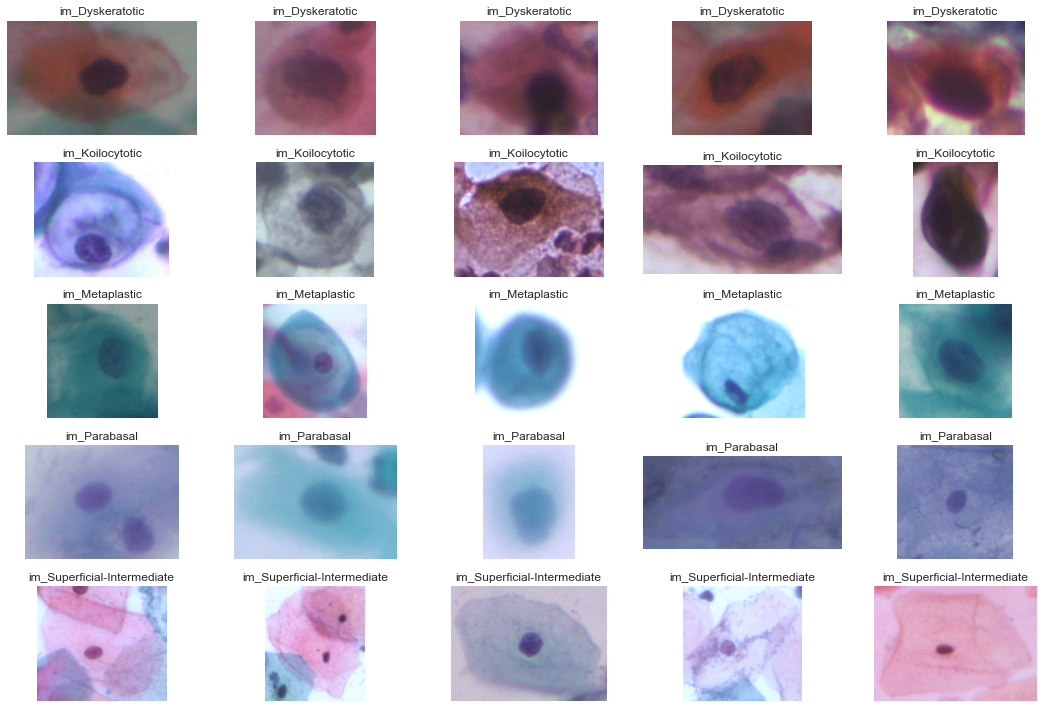

In [9]:
display_images_from_folders(base_dir, categories, num_images=5)

In [11]:
import os
from PIL import Image, ImageFilter, ImageOps
from pathlib import Path

def FormatDataset(dataset_src, dataset_dest, classes,
                  cropped_size=64, complete_size=256,
                  cropped_border=1, complete_border=2,
                  blur_radius=1):
    """
    Format cervical cell images using Pillow (no OpenCV):
    - Resize images
    - Add constant black border
    - Apply slight blur
    - Save as JPEG
    """
    def process_images(src_dir, dest_dir, size, border):
        Path(dest_dir).mkdir(parents=True, exist_ok=True)
        for file in os.listdir(src_dir):
            if file.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png')):
                with Image.open(os.path.join(src_dir, file)) as img:
                    img = img.convert("RGB")                # Ensure RGB
                    img = img.resize((size, size))         # Resize
                    img = ImageOps.expand(img, border, fill=0)  # Add black border
                    img = img.filter(ImageFilter.GaussianBlur(blur_radius))  # Blur
                    out_path = Path(dest_dir) / (Path(file).stem + '.jpg')
                    img.save(out_path, "JPEG")

    for cls in classes:
        cropped_src = Path(dataset_src) / f"{cls}" / f"{cls}" / "CROPPED"
        complete_src = Path(dataset_src) / f"{cls}" / f"{cls}"
        
        cropped_dest = Path(dataset_dest) / cls / "CROPPED"
        complete_dest = Path(dataset_dest) / cls / "COMPLETE"
        
        process_images(cropped_src, cropped_dest, cropped_size, cropped_border)
        process_images(complete_src, complete_dest, complete_size, complete_border)

    print(f"Dataset formatted at '{dataset_dest}'")

# Example usage
src = './cervical_cancer_data'
dest = './cervical_cancer_data/processed'
FormatDataset(src, dest, categories)


Dataset formatted at './cervical_cancer_data/processed'


In [ ]:
import shutil

def TrainValTestSplit(root_dir, classes, main="CROPPED", val_ratio=0.15, test_ratio=0.15):
    root_dir = Path(root_dir)

    for cls in classes:
        # Create split folders inside processed
        for split in ['train', 'val', 'test']:
            Path(root_dir, split, cls).mkdir(parents=True, exist_ok=True)
        
        # Get and shuffle file list
        src = Path(root_dir, cls, main)
        all_files = [f for f in os.listdir(src) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        np.random.shuffle(all_files)

        # Split indices
        train_end = int(len(all_files) * (1 - (val_ratio + test_ratio)))
        val_end = int(len(all_files) * (1 - test_ratio))
        splits = {
            'train': all_files[:train_end],
            'val': all_files[train_end:val_end],
            'test': all_files[val_end:]
        }

        # Print details and copy
        print(f"{cls}: Total={len(all_files)} Train={len(splits['train'])} Val={len(splits['val'])} Test={len(splits['test'])}")
        for split, files in splits.items():
            for file in files:
                shutil.copy(src / file, Path(root_dir, split, cls))

# Example usage
root_dir = "/Users/katherine/PycharmProjects/breast_cancer/cervical_cancer_data/processed"
TrainValTestSplit(root_dir, categories)


This dataset is pretty evenly split so no need to do resampling. If were to do though the code would look like:

In [ ]:
#from imblearn.over_sampling import RandomOverSampler

#ros = RandomOverSampler(random_state=42)
#X_resampled, y_resampled = ros.fit_resample(df_image_paths[['image_path']], df_image_paths['label'])
#df_resampled = pd.DataFrame(X_resampled, columns=['image_path'])
#df_resampled['label'] = y_resampled
#print("\nClass distribution after oversampling:")
#print(df_resampled['label'].value_counts())

### Modeling

Import Keras and generate new data.

In [2]:
import keras
from keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout
from keras.models import Sequential
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, GaussianNoise, Input, MultiHeadAttention, Reshape
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

import tensorflow as tf

from sklearn.metrics import classification_report

In [3]:
# Expand the size of dataset with new transformed images from the original dataset using ImageDataGenerator.
train_datagen = image.ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2 , rescale = 1./255 , horizontal_flip=True)
val_datagen = image.ImageDataGenerator(rescale = 1./255)
test_datagen = image.ImageDataGenerator(rescale = 1./255)

In [6]:

model = Sequential() 
# Convolutional Layer with input shape (64,64,3)
model.add(Conv2D(filters=16, kernel_size= (3,3), activation= 'relu', input_shape=(64,64,3)) )

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=5, activation='sigmoid'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']  )
 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 16)        448       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 128)        

Confirm working directory and connect data flow.

In [4]:
import os
os.getcwd()

'/Users/katherine/PycharmProjects/breast_cancer'

In [5]:
train_data = train_datagen.flow_from_directory(directory= "./cervical_cancer_data/processed/train", target_size=(64, 64), batch_size=100, class_mode = 'categorical')
val_data = val_datagen.flow_from_directory(directory= "./cervical_cancer_data/processed/val", target_size=(64, 64), batch_size=100, class_mode = 'categorical')
test_data = test_datagen.flow_from_directory(directory= "./cervical_cancer_data/processed/test", target_size=(64, 64), batch_size=100, class_mode = 'categorical', shuffle = False)

Found 2832 images belonging to 5 classes.
Found 608 images belonging to 5 classes.
Found 609 images belonging to 5 classes.


In [6]:
train_data.class_indices

{'im_Dyskeratotic': 0,
 'im_Koilocytotic': 1,
 'im_Metaplastic': 2,
 'im_Parabasal': 3,
 'im_Superficial-Intermediate': 4}

Add early stopping.

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [28]:
# Adding Model check point Callback
mc = ModelCheckpoint(filepath="cervical_cancer_best_model.hdf5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto');
call_back = [ mc ];

# Fitting the Model
cnn = model.fit(train_data, 
                  steps_per_epoch= 28, 
                  epochs= 32,
                  validation_data= val_data, 
                  validation_steps= 6,
                  callbacks = [early_stopping, call_back],
                  verbose = 1)

Epoch 1/32
28/28 [==============================] - 10s 350ms/step - loss: 0.2821 - accuracy: 0.8957 - val_loss: 0.3728 - val_accuracy: 0.8633

Epoch 00001: val_accuracy improved from -inf to 0.86333, saving model to cervical_cancer_best_model.hdf5
Epoch 2/32
28/28 [==============================] - 8s 292ms/step - loss: 0.2718 - accuracy: 0.9081 - val_loss: 0.2853 - val_accuracy: 0.9033

Epoch 00002: val_accuracy improved from 0.86333 to 0.90333, saving model to cervical_cancer_best_model.hdf5
Epoch 3/32
28/28 [==============================] - 8s 291ms/step - loss: 0.2211 - accuracy: 0.9195 - val_loss: 0.2636 - val_accuracy: 0.9067

Epoch 00003: val_accuracy improved from 0.90333 to 0.90667, saving model to cervical_cancer_best_model.hdf5
Epoch 4/32
28/28 [==============================] - 8s 297ms/step - loss: 0.2174 - accuracy: 0.9202 - val_loss: 0.2388 - val_accuracy: 0.9150

Epoch 00004: val_accuracy improved from 0.90667 to 0.91500, saving model to cervical_cancer_best_model.hdf

In [30]:
# Loading the Best Fit Model 
model= load_model("./cervical_cancer_best_model.hdf5")



In [67]:
# Checking the Accuracy of the Model 
accuracy = model.evaluate(test_data)[1]
print(f"The accuracy of your model is = {accuracy*100} %")

7/7 [==============================] - 0s 57ms/step - loss: 0.2040 - accuracy: 0.9343
The accuracy of your model is = 93.43185424804688 %


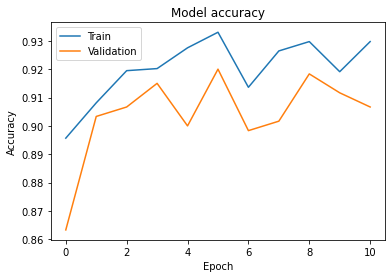

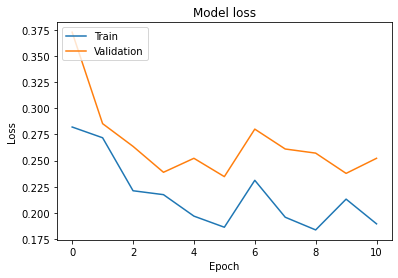

In [39]:
plt.plot(cnn.history['accuracy'])
plt.plot(cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(cnn.history['loss'])
plt.plot(cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.show()

In [34]:
def cancerPrediction(path):
    classes_dir = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]
    # Loading Image
    img = image.load_img(path, target_size=(64,64))
    # Normalizing Image
    norm_img = image.img_to_array(img)/255
    # Converting Image to Numpy Array
    input_arr_img = np.array([norm_img])
    # Getting Predictions
    pred = np.argmax(model.predict(input_arr_img))
    # Printing Model Prediction
    print(classes_dir[pred])

path = "./cervical_cancer_data/im_Dyskeratotic/im_Dyskeratotic/CROPPED/002_04.bmp"
cancerPrediction(path)

Dyskeratotic


In [49]:
test_labels = test_data.classes  
predictions = model.predict(test_data)  

predicted_classes = np.argmax(predictions, axis=1)

In [50]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_data.class_indices.keys()))
print(report)

                             precision    recall  f1-score   support

            im_Dyskeratotic       0.95      0.96      0.96       122
            im_Koilocytotic       0.89      0.88      0.88       124
             im_Metaplastic       0.95      0.93      0.94       119
               im_Parabasal       0.97      0.97      0.97       119
im_Superficial-Intermediate       0.92      0.93      0.92       125

                   accuracy                           0.93       609
                  macro avg       0.93      0.93      0.93       609
               weighted avg       0.93      0.93      0.93       609



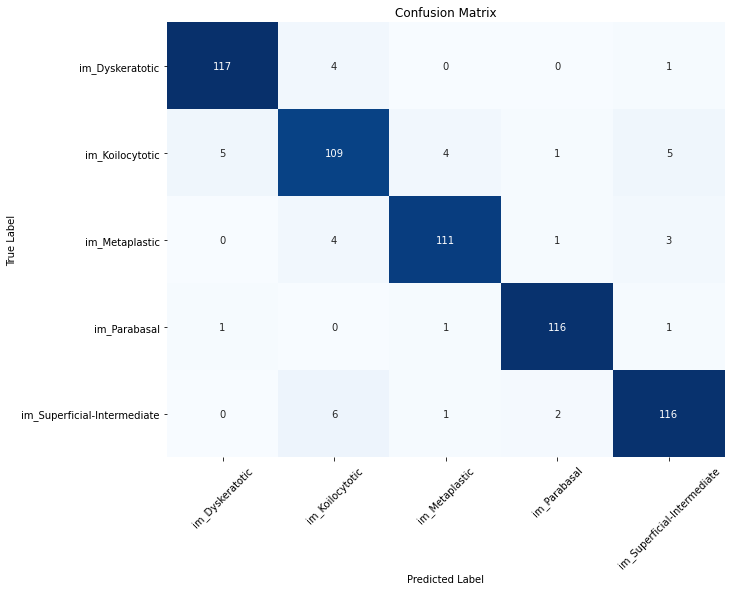

In [59]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=list(test_data.class_indices.keys()),
    yticklabels=list(test_data.class_indices.keys()),
    cbar=False
)
plt.xticks(rotation=45)   # optional: tilt x-axis labels for readability
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Xception Model

In [53]:
train_data = train_datagen.flow_from_directory(directory= "./cervical_cancer_data/processed/train", target_size=(160, 160), batch_size=100, class_mode = 'categorical')
val_data = val_datagen.flow_from_directory(directory= "./cervical_cancer_data/processed/val", target_size=(160, 160), batch_size=100, class_mode = 'categorical')
test_data = test_datagen.flow_from_directory(directory= "./cervical_cancer_data/processed/test", target_size=(160, 160), batch_size=100, class_mode = 'categorical', shuffle = False)

Found 2832 images belonging to 5 classes.
Found 608 images belonging to 5 classes.
Found 609 images belonging to 5 classes.


In [8]:
#xception model with attention
def create_xception_model(input_shape):
    
    inputs = Input(shape=input_shape)
    
    base_model = Xception(weights='imagenet', input_tensor=inputs, include_top=False)
    
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output

    height = K.int_shape(x)[1]  # will be 10 for 299x299 input
    width = K.int_shape(x)[2]   # will be 10
    channels = K.int_shape(x)[3]  # 2048

    x = Reshape((height * width, channels))(x)
   
    attention_output = MultiHeadAttention(num_heads=8, key_dim=channels)(x, x) 

    attention_output = Reshape((height, width, channels))(attention_output)
    
    x = GaussianNoise(0.25)(attention_output)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.25)(x)
    x = Dropout(0.25)(x)
    outputs = Dense(5, activation='softmax')(x)  

    model = Model(inputs=inputs, outputs=outputs)

    return model

input_shape = (160, 160, 3)
xcep = create_xception_model(input_shape)

xcep.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [11]:
# Adding Model check point Callback
mc = ModelCheckpoint(filepath="cervical_cancer_best_model_xcep.hdf5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto');
call_back = [ mc ];

xcep_history = xcep.fit(
    train_data,
    validation_data=val_data,
    epochs=10,  
    callbacks=[early_stopping, call_back],
    verbose=1
)

Epoch 1/10
29/29 [==============================] - 456s 16s/step - loss: 1.1149 - accuracy: 0.6195 - val_loss: 0.9558 - val_accuracy: 0.7385

Epoch 00001: val_accuracy improved from -inf to 0.73849, saving model to cervical_cancer_best_model_xcep.hdf5
Epoch 2/10
29/29 [==============================] - 497s 17s/step - loss: 0.5621 - accuracy: 0.8076 - val_loss: 0.7810 - val_accuracy: 0.8257

Epoch 00002: val_accuracy improved from 0.73849 to 0.82566, saving model to cervical_cancer_best_model_xcep.hdf5
Epoch 3/10
29/29 [==============================] - 445s 15s/step - loss: 0.4656 - accuracy: 0.8215 - val_loss: 0.6131 - val_accuracy: 0.8421

Epoch 00003: val_accuracy improved from 0.82566 to 0.84211, saving model to cervical_cancer_best_model_xcep.hdf5
Epoch 4/10
29/29 [==============================] - 2353s 84s/step - loss: 0.4599 - accuracy: 0.8410 - val_loss: 0.5643 - val_accuracy: 0.8487

Epoch 00004: val_accuracy improved from 0.84211 to 0.84868, saving model to cervical_cancer

In [12]:
print(xcep.input_shape)
print(test_data.target_size)
images, labels = next(test_data)
print(images.shape)

(None, 160, 160, 3)
(160, 160)
(100, 160, 160, 3)


In [13]:
# Loading the Best Fit Model 
xcep = load_model("./cervical_cancer_best_model_xcep.hdf5")
accuracy = xcep.evaluate(test_data)[1]
print(f"The accuracy of your model is = {accuracy*100} %")

7/7 [==============================] - 38s 5s/step - loss: 0.4378 - accuracy: 0.8489
The accuracy of your model is = 84.8932683467865 %


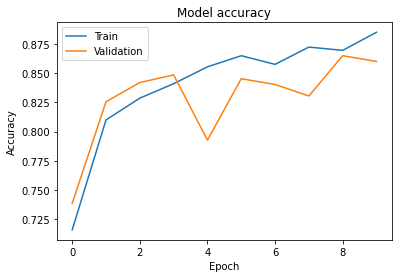

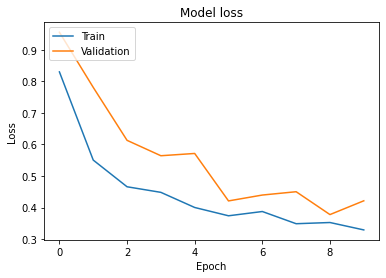

                             precision    recall  f1-score   support

            im_Dyskeratotic       0.89      0.87      0.88       122
            im_Koilocytotic       0.70      0.78      0.74       124
             im_Metaplastic       0.85      0.79      0.82       119
               im_Parabasal       0.96      0.88      0.92       119
im_Superficial-Intermediate       0.86      0.92      0.89       125

                   accuracy                           0.85       609
                  macro avg       0.86      0.85      0.85       609
               weighted avg       0.85      0.85      0.85       609



In [19]:
plt.plot(xcep_history.history['accuracy'])
plt.plot(xcep_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(xcep_history.history['loss'])
plt.plot(xcep_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

test_labels = test_data.classes  
predictions = xcep.predict(test_data)  
predicted_classes = np.argmax(predictions, axis=1)

report = classification_report(test_labels, predicted_classes, target_names=list(test_data.class_indices.keys()))

print(report)




## Using Reptile

The Reptile algorithm was developed by OpenAI to perform model-agnostic meta-learning. Specifically, this algorithm was designed to quickly learn to perform new tasks with minimal training (few-shot learning). The algorithm works by performing Stochastic Gradient Descent using the difference between weights trained on a mini-batch of never-seen-before data and the model weights prior to training over a fixed number of meta-iterations.

This section is WIP.

In [134]:
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 16
eval_batch_size = 16

meta_iters = 1000
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
classes = 5
num_classes = 5

In [110]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

IMG_SIZE = (64, 64)
BATCH_SIZE = 32


def load_data_from_dir(directory):
    """
    Loads all images from a directory into memory as NumPy arrays.
    Directory should have a subfolder per class.
    
    Returns:
        images: numpy array of shape (N, 160, 160, 3)
        labels: numpy array of shape (N,) with integer labels
    """
    datagen = ImageDataGenerator(rescale=1./255)

    data_iter = datagen.flow_from_directory(
        directory=directory,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='sparse',  # ensures integer labels
        shuffle=False         # don’t shuffle so order is consistent
    )

    images, labels = [], []
    
    # Iterate through all batches
    for _ in range(len(data_iter)):
        x, y = next(data_iter)   # x=(batch,160,160,3), y=(batch,)
        images.append(x)
        labels.append(y)

    # Stack into full arrays
    images = np.vstack(images)                   # shape (N,64,64,3)
    labels = np.concatenate(labels).astype(int)  # shape (N,)
    print(images.shape)
    print(labels.shape)
    
    return images, labels

train_images, train_labels = load_data_from_dir("./cervical_cancer_data/processed/train")
val_images, val_labels = load_data_from_dir("./cervical_cancer_data/processed/val")

Found 2832 images belonging to 5 classes.
(2832, 64, 64, 3)
(2832,)
Found 608 images belonging to 5 classes.
(608, 64, 64, 3)
(608,)


In [129]:
import random
        
class FewShotDataset:
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.unique_classes = np.unique(labels)
        self.data = {label: images[labels == label] for label in self.unique_classes}

    def get_mini_dataset(self, batch_size, repetitions, shots, num_classes, split = False):

        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, 64, 64, 3))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 64, 64, 3))
            
        label_subset = random.choices(self.labels, k=num_classes)
        print(label_subset)

        for class_idx, class_obj in enumerate(label_subset):
            print(class_idx, class_obj)
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                selected_images = random.choices(self.data[label_subset[class_idx]], k=shots)
                print(np.array(selected_images).shape)
                print(temp_images.shape)
                print(self.images.shape)
                temp_images[class_idx * shots : (class_idx + 1) * shots] = np.array(selected_images)
        
        ds = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32)))
        ds = ds.shuffle(100).batch(batch_size).repeat(inner_iters)
        if split:
            return ds, test_images, test_labels
        return ds



In [130]:
train_images.shape

(2832, 64, 64, 3)

In [131]:
from keras import layers

def conv_bn(x):
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)


inputs = layers.Input(shape=(64, 64, 3))
x = conv_bn(inputs)
x = conv_bn(x)
x = conv_bn(x)
x = conv_bn(x)
x = layers.Flatten()(x)
outputs = layers.Dense(classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile()
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)



In [147]:
train_dataset = FewShotDataset(train_images, train_labels)
test_dataset = FewShotDataset(val_images, val_labels)

In [136]:
training = []
testing = []
for meta_iter in range(meta_iters):
    print('iteration: ', meta_iter)
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # Temporarily save the weights from the model.
    old_vars = model.get_weights()
    # Get a sample from the full dataset.
    mini_dataset = train_dataset.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes
    )
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    new_vars = model.get_weights()
    # Perform SGD for the meta step.
    for var in range(len(new_vars)):
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
        )
    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_vars)
    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies = []
        for dataset in (train_dataset, test_dataset):
            # Sample a mini dataset from the full dataset.
            train_set, test_images, test_labels = dataset.get_mini_dataset(
                eval_batch_size, eval_iters, shots, classes, split=True
            )
            old_vars = model.get_weights()
            # Train on the samples and get the resulting accuracies.
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = model(images)
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
            test_preds = model.predict(test_images)
            test_preds = tf.argmax(test_preds).numpy()
            num_correct = (test_preds == test_labels).sum()
            # Reset the weights after getting the evaluation accuracies.
            model.set_weights(old_vars)
            accuracies.append(num_correct / classes)
        training.append(accuracies[0])
        testing.append(accuracies[1])
        if meta_iter % 100 == 0:
            print(
                "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
            )

iteration:  0
[4, 0, 2, 0, 0]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[2, 0, 3, 0, 4]
0 2
1 0
2 3
3 0
4 4
[0, 1, 3, 1, 4]
0 0
1 1
2 3
3 1
4 4
batch 0: train=0.400000 test=0.600000
iteration:  1
[4, 4, 1, 0, 4]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[3, 2, 4, 2, 0]
0 3
1 2
2 4
3 2
4 0
[4, 0, 2, 2, 2]
0 4
1 0
2 2
3 2
4 2
iteration:  2
[2, 1, 1, 4, 3]
0 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 4
(20, 64, 

[3, 3, 4, 1, 2]
0 3
1 3
2 4
3 1
4 2
[0, 1, 0, 2, 4]
0 0
1 1
2 0
3 2
4 4
iteration:  22
[1, 0, 4, 0, 3]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[2, 0, 4, 4, 4]
0 2
1 0
2 4
3 4
4 4
[3, 1, 4, 3, 1]
0 3
1 1
2 4
3 3
4 1
iteration:  23
[1, 2, 3, 2, 3]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[0, 0, 3, 2, 3]
0 0
1 0
2 3
3 2
4 3
[4, 4, 3, 2, 0]
0 4
1 4
2 3
3 2
4 0
iteration:  24
[1, 0, 4, 3, 1]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(20, 64, 64, 3)
(100, 64, 6

[1, 1, 4, 1, 4]
0 1
1 1
2 4
3 1
4 4
[1, 1, 1, 4, 4]
0 1
1 1
2 1
3 4
4 4
iteration:  44
[0, 1, 1, 1, 4]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[1, 4, 3, 4, 0]
0 1
1 4
2 3
3 4
4 0
[2, 2, 1, 1, 2]
0 2
1 2
2 1
3 1
4 2
iteration:  45
[2, 1, 4, 3, 3]
0 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[0, 4, 2, 3, 4]
0 0
1 4
2 2
3 3
4 4
[2, 4, 3, 2, 3]
0 2
1 4
2 3
3 2
4 3
iteration:  46
[4, 3, 0, 4, 4]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 0
(20, 64, 64, 3)
(100, 64, 6

[2, 4, 0, 0, 2]
0 2
1 4
2 0
3 0
4 2
[0, 0, 2, 4, 0]
0 0
1 0
2 2
3 4
4 0
iteration:  66
[0, 4, 1, 3, 2]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[1, 2, 1, 4, 1]
0 1
1 2
2 1
3 4
4 1
[4, 2, 2, 1, 3]
0 4
1 2
2 2
3 1
4 3
iteration:  67
[1, 4, 2, 1, 0]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[2, 1, 2, 3, 2]
0 2
1 1
2 2
3 3
4 2
[0, 3, 3, 0, 2]
0 0
1 3
2 3
3 0
4 2
iteration:  68
[4, 1, 3, 1, 3]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 3
(20, 64, 64, 3)
(100, 64, 6

[2, 4, 2, 3, 3]
0 2
1 4
2 2
3 3
4 3
[1, 1, 4, 1, 4]
0 1
1 1
2 4
3 1
4 4
iteration:  88
[4, 1, 4, 1, 1]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[1, 2, 3, 2, 0]
0 1
1 2
2 3
3 2
4 0
[2, 3, 0, 1, 0]
0 2
1 3
2 0
3 1
4 0
iteration:  89
[4, 2, 1, 0, 0]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[2, 0, 3, 3, 1]
0 2
1 0
2 3
3 3
4 1
[0, 2, 0, 2, 2]
0 0
1 2
2 0
3 2
4 2
iteration:  90
[2, 1, 4, 2, 4]
0 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(20, 64, 64, 3)
(100, 64, 6

[0, 1, 4, 0, 4]
0 0
1 1
2 4
3 0
4 4
[0, 1, 4, 4, 2]
0 0
1 1
2 4
3 4
4 2
iteration:  110
[0, 0, 4, 1, 0]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[0, 2, 2, 0, 0]
0 0
1 2
2 2
3 0
4 0
[1, 0, 4, 2, 0]
0 1
1 0
2 4
3 2
4 0
iteration:  111
[1, 4, 2, 2, 3]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[4, 2, 4, 2, 4]
0 4
1 2
2 4
3 2
4 4
[0, 2, 2, 0, 4]
0 0
1 2
2 2
3 0
4 4
iteration:  112
[4, 1, 3, 4, 0]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 3
(20, 64, 64, 3)
(100, 64

[2, 3, 1, 4, 4]
0 2
1 3
2 1
3 4
4 4
[1, 3, 0, 4, 1]
0 1
1 3
2 0
3 4
4 1
iteration:  132
[0, 4, 1, 4, 2]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[2, 3, 3, 4, 4]
0 2
1 3
2 3
3 4
4 4
[1, 1, 3, 2, 2]
0 1
1 1
2 3
3 2
4 2
iteration:  133
[2, 4, 4, 1, 2]
0 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[4, 4, 2, 1, 2]
0 4
1 4
2 2
3 1
4 2
[4, 3, 0, 2, 3]
0 4
1 3
2 0
3 2
4 3
iteration:  134
[0, 4, 1, 4, 2]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64

[2, 0, 1, 1, 4]
0 2
1 0
2 1
3 1
4 4
[2, 2, 4, 1, 1]
0 2
1 2
2 4
3 1
4 1
iteration:  154
[0, 3, 1, 0, 3]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[0, 3, 4, 0, 4]
0 0
1 3
2 4
3 0
4 4
[3, 0, 4, 2, 1]
0 3
1 0
2 4
3 2
4 1
iteration:  155
[4, 2, 1, 1, 2]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[0, 2, 4, 0, 0]
0 0
1 2
2 4
3 0
4 0
[4, 3, 3, 3, 1]
0 4
1 3
2 3
3 3
4 1
iteration:  156
[3, 0, 3, 4, 4]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 3
(20, 64, 64, 3)
(100, 64

[4, 1, 2, 0, 4]
0 4
1 1
2 2
3 0
4 4
[4, 3, 3, 0, 0]
0 4
1 3
2 3
3 0
4 0
iteration:  176
[3, 0, 1, 4, 4]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[0, 2, 4, 4, 3]
0 0
1 2
2 4
3 4
4 3
[3, 0, 3, 1, 2]
0 3
1 0
2 3
3 1
4 2
iteration:  177
[2, 1, 4, 1, 4]
0 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[4, 0, 2, 0, 4]
0 4
1 0
2 2
3 0
4 4
[4, 0, 4, 3, 0]
0 4
1 0
2 4
3 3
4 0
iteration:  178
[1, 0, 3, 4, 0]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 3
(20, 64, 64, 3)
(100, 64

[4, 4, 0, 3, 2]
0 4
1 4
2 0
3 3
4 2
[2, 2, 4, 4, 1]
0 2
1 2
2 4
3 4
4 1
iteration:  198
[0, 2, 4, 1, 2]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[4, 3, 4, 2, 4]
0 4
1 3
2 4
3 2
4 4
[2, 4, 3, 0, 2]
0 2
1 4
2 3
3 0
4 2
iteration:  199
[3, 2, 2, 2, 2]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[2, 2, 1, 3, 0]
0 2
1 2
2 1
3 3
4 0
[4, 4, 4, 1, 0]
0 4
1 4
2 4
3 1
4 0
iteration:  200
[3, 1, 3, 3, 0]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 3
(20, 64, 64, 3)
(100, 64

[0, 0, 4, 1, 3]
0 0
1 0
2 4
3 1
4 3
[2, 2, 3, 4, 2]
0 2
1 2
2 3
3 4
4 2
iteration:  220
[4, 2, 0, 0, 2]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[0, 3, 0, 3, 1]
0 0
1 3
2 0
3 3
4 1
[0, 1, 1, 0, 0]
0 0
1 1
2 1
3 0
4 0
iteration:  221
[4, 0, 4, 0, 0]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[3, 3, 1, 0, 1]
0 3
1 3
2 1
3 0
4 1
[1, 3, 1, 3, 3]
0 1
1 3
2 1
3 3
4 3
iteration:  222
[3, 2, 4, 4, 0]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(20, 64, 64, 3)
(100, 64

[3, 2, 2, 3, 4]
0 3
1 2
2 2
3 3
4 4
[1, 1, 3, 2, 2]
0 1
1 1
2 3
3 2
4 2
iteration:  242
[3, 3, 0, 3, 0]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[0, 0, 3, 2, 3]
0 0
1 0
2 3
3 2
4 3
[3, 0, 4, 1, 2]
0 3
1 0
2 4
3 1
4 2
iteration:  243
[0, 1, 4, 0, 3]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[1, 4, 2, 1, 2]
0 1
1 4
2 2
3 1
4 2
[1, 1, 1, 0, 2]
0 1
1 1
2 1
3 0
4 2
iteration:  244
[0, 0, 1, 4, 0]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64

[4, 0, 4, 4, 1]
0 4
1 0
2 4
3 4
4 1
[0, 4, 4, 3, 1]
0 0
1 4
2 4
3 3
4 1
iteration:  264
[1, 3, 1, 0, 0]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[0, 4, 0, 0, 4]
0 0
1 4
2 0
3 0
4 4
[1, 1, 3, 0, 1]
0 1
1 1
2 3
3 0
4 1
iteration:  265
[0, 3, 0, 4, 0]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[4, 3, 1, 4, 3]
0 4
1 3
2 1
3 4
4 3
[0, 4, 2, 1, 3]
0 0
1 4
2 2
3 1
4 3
iteration:  266
[1, 0, 4, 3, 1]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(20, 64, 64, 3)
(100, 64

[3, 3, 4, 1, 0]
0 3
1 3
2 4
3 1
4 0
[0, 4, 2, 1, 1]
0 0
1 4
2 2
3 1
4 1
iteration:  286
[3, 1, 2, 1, 4]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[2, 3, 0, 3, 4]
0 2
1 3
2 0
3 3
4 4
[0, 4, 0, 0, 2]
0 0
1 4
2 0
3 0
4 2
iteration:  287
[4, 3, 3, 0, 0]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[1, 0, 0, 1, 0]
0 1
1 0
2 0
3 1
4 0
[0, 1, 3, 3, 2]
0 0
1 1
2 3
3 3
4 2
iteration:  288
[3, 2, 1, 2, 4]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64

[4, 0, 3, 1, 3]
0 4
1 0
2 3
3 1
4 3
[4, 2, 0, 0, 2]
0 4
1 2
2 0
3 0
4 2
iteration:  308
[1, 2, 3, 2, 0]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[1, 0, 3, 0, 4]
0 1
1 0
2 3
3 0
4 4
[4, 2, 1, 0, 0]
0 4
1 2
2 1
3 0
4 0
iteration:  309
[2, 4, 0, 3, 4]
0 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[2, 2, 4, 3, 3]
0 2
1 2
2 4
3 3
4 3
[0, 3, 3, 4, 1]
0 0
1 3
2 3
3 4
4 1
iteration:  310
[0, 3, 2, 1, 0]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 2
(20, 64, 64, 3)
(100, 64

[4, 3, 4, 3, 1]
0 4
1 3
2 4
3 3
4 1
[1, 1, 2, 1, 4]
0 1
1 1
2 2
3 1
4 4
iteration:  330
[1, 4, 3, 1, 0]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[1, 3, 0, 1, 3]
0 1
1 3
2 0
3 1
4 3
[3, 0, 1, 1, 2]
0 3
1 0
2 1
3 1
4 2
iteration:  331
[3, 1, 1, 0, 1]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[3, 1, 4, 3, 3]
0 3
1 1
2 4
3 3
4 3
[1, 2, 4, 4, 2]
0 1
1 2
2 4
3 4
4 2
iteration:  332
[2, 1, 0, 2, 3]
0 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 0
(20, 64, 64, 3)
(100, 64

[3, 0, 3, 1, 2]
0 3
1 0
2 3
3 1
4 2
[4, 4, 3, 2, 0]
0 4
1 4
2 3
3 2
4 0
iteration:  352
[3, 0, 3, 0, 0]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[0, 4, 0, 3, 3]
0 0
1 4
2 0
3 3
4 3
[4, 2, 4, 0, 4]
0 4
1 2
2 4
3 0
4 4
iteration:  353
[1, 1, 2, 3, 4]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[0, 0, 3, 4, 1]
0 0
1 0
2 3
3 4
4 1
[1, 1, 2, 0, 2]
0 1
1 1
2 2
3 0
4 2
iteration:  354
[0, 2, 2, 2, 0]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 2
(20, 64, 64, 3)
(100, 64

[2, 4, 3, 0, 1]
0 2
1 4
2 3
3 0
4 1
[4, 3, 1, 3, 4]
0 4
1 3
2 1
3 3
4 4
iteration:  374
[3, 0, 1, 1, 4]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[1, 4, 1, 2, 0]
0 1
1 4
2 1
3 2
4 0
[1, 1, 4, 2, 3]
0 1
1 1
2 4
3 2
4 3
iteration:  375
[0, 2, 4, 2, 2]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[4, 1, 0, 2, 3]
0 4
1 1
2 0
3 2
4 3
[4, 4, 4, 1, 3]
0 4
1 4
2 4
3 1
4 3
iteration:  376
[1, 3, 1, 3, 2]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64

[4, 4, 0, 3, 3]
0 4
1 4
2 0
3 3
4 3
[0, 0, 1, 4, 3]
0 0
1 0
2 1
3 4
4 3
iteration:  396
[1, 3, 0, 0, 3]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[4, 3, 0, 1, 0]
0 4
1 3
2 0
3 1
4 0
[4, 4, 2, 1, 2]
0 4
1 4
2 2
3 1
4 2
iteration:  397
[0, 3, 4, 2, 4]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[0, 2, 2, 2, 2]
0 0
1 2
2 2
3 2
4 2
[2, 1, 1, 3, 4]
0 2
1 1
2 1
3 3
4 4
iteration:  398
[0, 4, 3, 2, 4]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 3
(20, 64, 64, 3)
(100, 64

[4, 0, 2, 0, 4]
0 4
1 0
2 2
3 0
4 4
[2, 3, 3, 1, 1]
0 2
1 3
2 3
3 1
4 1
iteration:  418
[3, 1, 0, 1, 0]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[3, 1, 4, 1, 2]
0 3
1 1
2 4
3 1
4 2
[4, 4, 0, 1, 0]
0 4
1 4
2 0
3 1
4 0
iteration:  419
[4, 0, 3, 0, 0]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[3, 0, 1, 3, 3]
0 3
1 0
2 1
3 3
4 3
[0, 4, 1, 3, 3]
0 0
1 4
2 1
3 3
4 3
iteration:  420
[2, 2, 3, 3, 0]
0 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 3
(20, 64, 64, 3)
(100, 64

[0, 0, 4, 4, 0]
0 0
1 0
2 4
3 4
4 0
[2, 4, 0, 4, 4]
0 2
1 4
2 0
3 4
4 4
iteration:  440
[3, 0, 1, 2, 1]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[2, 0, 1, 0, 1]
0 2
1 0
2 1
3 0
4 1
[4, 2, 2, 0, 2]
0 4
1 2
2 2
3 0
4 2
iteration:  441
[3, 2, 2, 3, 3]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[1, 3, 1, 1, 0]
0 1
1 3
2 1
3 1
4 0
[2, 1, 3, 1, 4]
0 2
1 1
2 3
3 1
4 4
iteration:  442
[1, 3, 2, 3, 3]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 2
(20, 64, 64, 3)
(100, 64

[2, 3, 1, 3, 1]
0 2
1 3
2 1
3 3
4 1
[2, 2, 0, 2, 0]
0 2
1 2
2 0
3 2
4 0
iteration:  462
[4, 1, 2, 2, 0]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[3, 1, 3, 2, 0]
0 3
1 1
2 3
3 2
4 0
[1, 0, 4, 1, 0]
0 1
1 0
2 4
3 1
4 0
iteration:  463
[4, 4, 3, 1, 2]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[0, 3, 2, 3, 0]
0 0
1 3
2 2
3 3
4 0
[3, 1, 4, 0, 1]
0 3
1 1
2 4
3 0
4 1
iteration:  464
[0, 4, 1, 3, 0]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64

[2, 0, 1, 0, 1]
0 2
1 0
2 1
3 0
4 1
[4, 1, 1, 2, 3]
0 4
1 1
2 1
3 2
4 3
iteration:  484
[0, 2, 3, 3, 3]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[1, 1, 0, 4, 4]
0 1
1 1
2 0
3 4
4 4
[1, 1, 4, 1, 4]
0 1
1 1
2 4
3 1
4 4
iteration:  485
[1, 3, 3, 4, 1]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[1, 2, 1, 3, 0]
0 1
1 2
2 1
3 3
4 0
[1, 4, 4, 1, 1]
0 1
1 4
2 4
3 1
4 1
iteration:  486
[3, 4, 0, 0, 4]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 0
(20, 64, 64, 3)
(100, 64

[4, 1, 0, 0, 0]
0 4
1 1
2 0
3 0
4 0
[1, 3, 4, 1, 3]
0 1
1 3
2 4
3 1
4 3
iteration:  506
[4, 1, 4, 4, 4]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[0, 3, 0, 4, 4]
0 0
1 3
2 0
3 4
4 4
[2, 3, 0, 0, 1]
0 2
1 3
2 0
3 0
4 1
iteration:  507
[3, 0, 1, 4, 0]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[4, 3, 3, 3, 4]
0 4
1 3
2 3
3 3
4 4
[0, 4, 4, 0, 0]
0 0
1 4
2 4
3 0
4 0
iteration:  508
[0, 2, 0, 2, 0]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 0
(20, 64, 64, 3)
(100, 64

[2, 2, 4, 0, 2]
0 2
1 2
2 4
3 0
4 2
[2, 0, 1, 0, 0]
0 2
1 0
2 1
3 0
4 0
iteration:  528
[4, 1, 0, 4, 2]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[2, 2, 2, 1, 0]
0 2
1 2
2 2
3 1
4 0
[4, 4, 1, 4, 0]
0 4
1 4
2 1
3 4
4 0
iteration:  529
[2, 4, 1, 3, 3]
0 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[1, 4, 4, 4, 1]
0 1
1 4
2 4
3 4
4 1
[3, 4, 4, 0, 2]
0 3
1 4
2 4
3 0
4 2
iteration:  530
[2, 0, 1, 1, 1]
0 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64

[3, 1, 4, 2, 3]
0 3
1 1
2 4
3 2
4 3
[2, 1, 0, 2, 2]
0 2
1 1
2 0
3 2
4 2
iteration:  550
[1, 2, 4, 4, 4]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[0, 1, 4, 3, 0]
0 0
1 1
2 4
3 3
4 0
[4, 1, 2, 0, 2]
0 4
1 1
2 2
3 0
4 2
iteration:  551
[1, 0, 2, 2, 0]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[3, 4, 2, 4, 2]
0 3
1 4
2 2
3 4
4 2
[3, 1, 1, 1, 0]
0 3
1 1
2 1
3 1
4 0
iteration:  552
[3, 1, 1, 1, 2]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64

[3, 3, 0, 4, 3]
0 3
1 3
2 0
3 4
4 3
[4, 4, 2, 4, 0]
0 4
1 4
2 2
3 4
4 0
iteration:  572
[3, 2, 0, 3, 2]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[2, 4, 1, 4, 4]
0 2
1 4
2 1
3 4
4 4
[0, 4, 2, 1, 2]
0 0
1 4
2 2
3 1
4 2
iteration:  573
[1, 4, 0, 0, 2]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[3, 4, 3, 3, 2]
0 3
1 4
2 3
3 3
4 2
[0, 1, 4, 4, 0]
0 0
1 1
2 4
3 4
4 0
iteration:  574
[4, 4, 2, 4, 1]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 2
(20, 64, 64, 3)
(100, 64

[0, 1, 1, 3, 1]
0 0
1 1
2 1
3 3
4 1
[4, 2, 3, 3, 2]
0 4
1 2
2 3
3 3
4 2
iteration:  594
[4, 4, 3, 0, 4]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[1, 2, 0, 0, 4]
0 1
1 2
2 0
3 0
4 4
[0, 1, 3, 1, 4]
0 0
1 1
2 3
3 1
4 4
iteration:  595
[4, 1, 1, 2, 4]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[0, 3, 3, 1, 0]
0 0
1 3
2 3
3 1
4 0
[0, 0, 0, 1, 0]
0 0
1 0
2 0
3 1
4 0
iteration:  596
[2, 1, 0, 3, 4]
0 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 0
(20, 64, 64, 3)
(100, 64

[3, 0, 2, 0, 0]
0 3
1 0
2 2
3 0
4 0
[0, 4, 1, 4, 1]
0 0
1 4
2 1
3 4
4 1
iteration:  616
[3, 1, 4, 0, 2]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[4, 1, 4, 1, 0]
0 4
1 1
2 4
3 1
4 0
[1, 2, 0, 1, 1]
0 1
1 2
2 0
3 1
4 1
iteration:  617
[4, 1, 2, 0, 3]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[1, 3, 0, 1, 3]
0 1
1 3
2 0
3 1
4 3
[0, 1, 2, 1, 1]
0 0
1 1
2 2
3 1
4 1
iteration:  618
[1, 0, 2, 3, 1]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 2
(20, 64, 64, 3)
(100, 64

[0, 1, 4, 2, 1]
0 0
1 1
2 4
3 2
4 1
[3, 2, 1, 4, 4]
0 3
1 2
2 1
3 4
4 4
iteration:  638
[1, 3, 1, 4, 1]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[0, 4, 2, 3, 0]
0 0
1 4
2 2
3 3
4 0
[1, 0, 4, 3, 4]
0 1
1 0
2 4
3 3
4 4
iteration:  639
[2, 1, 2, 3, 0]
0 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[1, 0, 1, 3, 2]
0 1
1 0
2 1
3 3
4 2
[4, 3, 0, 3, 1]
0 4
1 3
2 0
3 3
4 1
iteration:  640
[4, 1, 1, 0, 2]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64

[2, 4, 4, 1, 4]
0 2
1 4
2 4
3 1
4 4
[3, 4, 4, 1, 4]
0 3
1 4
2 4
3 1
4 4
iteration:  660
[2, 0, 1, 1, 3]
0 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[4, 1, 0, 4, 0]
0 4
1 1
2 0
3 4
4 0
[4, 2, 1, 0, 4]
0 4
1 2
2 1
3 0
4 4
iteration:  661
[1, 2, 0, 0, 0]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[1, 3, 3, 2, 0]
0 1
1 3
2 3
3 2
4 0
[2, 4, 2, 0, 0]
0 2
1 4
2 2
3 0
4 0
iteration:  662
[1, 0, 4, 0, 2]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(20, 64, 64, 3)
(100, 64

[2, 2, 3, 2, 4]
0 2
1 2
2 3
3 2
4 4
[1, 4, 1, 3, 0]
0 1
1 4
2 1
3 3
4 0
iteration:  682
[2, 2, 4, 1, 4]
0 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[1, 0, 4, 4, 2]
0 1
1 0
2 4
3 4
4 2
[3, 4, 1, 1, 1]
0 3
1 4
2 1
3 1
4 1
iteration:  683
[1, 2, 1, 3, 3]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[3, 4, 4, 1, 3]
0 3
1 4
2 4
3 1
4 3
[1, 4, 4, 3, 4]
0 1
1 4
2 4
3 3
4 4
iteration:  684
[1, 1, 0, 4, 2]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 0
(20, 64, 64, 3)
(100, 64

[0, 1, 0, 4, 1]
0 0
1 1
2 0
3 4
4 1
[2, 3, 1, 4, 1]
0 2
1 3
2 1
3 4
4 1
iteration:  704
[1, 2, 1, 1, 2]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[3, 4, 3, 2, 2]
0 3
1 4
2 3
3 2
4 2
[3, 0, 0, 0, 3]
0 3
1 0
2 0
3 0
4 3
iteration:  705
[3, 1, 4, 0, 3]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[2, 1, 4, 0, 4]
0 2
1 1
2 4
3 0
4 4
[1, 2, 3, 0, 1]
0 1
1 2
2 3
3 0
4 1
iteration:  706
[3, 3, 3, 2, 3]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 3
(20, 64, 64, 3)
(100, 64

[0, 1, 3, 4, 4]
0 0
1 1
2 3
3 4
4 4
[4, 2, 0, 2, 3]
0 4
1 2
2 0
3 2
4 3
iteration:  726
[2, 4, 4, 2, 0]
0 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[3, 1, 4, 1, 1]
0 3
1 1
2 4
3 1
4 1
[3, 4, 4, 4, 3]
0 3
1 4
2 4
3 4
4 3
iteration:  727
[2, 0, 3, 1, 0]
0 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[0, 0, 4, 4, 0]
0 0
1 0
2 4
3 4
4 0
[1, 1, 0, 0, 0]
0 1
1 1
2 0
3 0
4 0
iteration:  728
[2, 4, 1, 4, 0]
0 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64

[3, 1, 1, 3, 1]
0 3
1 1
2 1
3 3
4 1
[4, 0, 3, 2, 2]
0 4
1 0
2 3
3 2
4 2
iteration:  748
[0, 1, 1, 3, 1]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[3, 4, 4, 1, 0]
0 3
1 4
2 4
3 1
4 0
[4, 4, 3, 2, 0]
0 4
1 4
2 3
3 2
4 0
iteration:  749
[0, 3, 2, 1, 4]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[0, 3, 1, 0, 4]
0 0
1 3
2 1
3 0
4 4
[4, 0, 4, 3, 0]
0 4
1 0
2 4
3 3
4 0
iteration:  750
[1, 1, 2, 0, 1]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 2
(20, 64, 64, 3)
(100, 64

[2, 1, 3, 4, 3]
0 2
1 1
2 3
3 4
4 3
[3, 4, 1, 2, 2]
0 3
1 4
2 1
3 2
4 2
iteration:  770
[2, 4, 4, 0, 0]
0 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[4, 0, 4, 2, 2]
0 4
1 0
2 4
3 2
4 2
[1, 0, 3, 0, 4]
0 1
1 0
2 3
3 0
4 4
iteration:  771
[1, 3, 2, 3, 4]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[1, 3, 4, 2, 4]
0 1
1 3
2 4
3 2
4 4
[2, 2, 1, 3, 2]
0 2
1 2
2 1
3 3
4 2
iteration:  772
[0, 2, 4, 4, 2]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(20, 64, 64, 3)
(100, 64

[4, 4, 0, 0, 4]
0 4
1 4
2 0
3 0
4 4
[4, 0, 1, 4, 2]
0 4
1 0
2 1
3 4
4 2
iteration:  792
[0, 0, 3, 2, 3]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[0, 1, 4, 0, 4]
0 0
1 1
2 4
3 0
4 4
[3, 3, 3, 2, 3]
0 3
1 3
2 3
3 2
4 3
iteration:  793
[1, 1, 2, 3, 0]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[2, 2, 4, 1, 0]
0 2
1 2
2 4
3 1
4 0
[3, 2, 4, 0, 1]
0 3
1 2
2 4
3 0
4 1
iteration:  794
[3, 0, 1, 1, 0]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64

[3, 0, 4, 2, 0]
0 3
1 0
2 4
3 2
4 0
[3, 4, 1, 0, 2]
0 3
1 4
2 1
3 0
4 2
iteration:  814
[2, 3, 0, 0, 0]
0 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[1, 0, 4, 2, 4]
0 1
1 0
2 4
3 2
4 4
[3, 1, 1, 0, 1]
0 3
1 1
2 1
3 0
4 1
iteration:  815
[4, 4, 2, 2, 1]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[4, 1, 4, 3, 1]
0 4
1 1
2 4
3 3
4 1
[2, 2, 3, 2, 3]
0 2
1 2
2 3
3 2
4 3
iteration:  816
[1, 4, 4, 0, 0]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(20, 64, 64, 3)
(100, 64

[2, 0, 0, 1, 0]
0 2
1 0
2 0
3 1
4 0
[3, 3, 2, 0, 2]
0 3
1 3
2 2
3 0
4 2
iteration:  836
[4, 3, 2, 2, 3]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[0, 1, 1, 1, 2]
0 0
1 1
2 1
3 1
4 2
[3, 4, 2, 4, 0]
0 3
1 4
2 2
3 4
4 0
iteration:  837
[3, 2, 0, 3, 1]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[4, 4, 0, 2, 3]
0 4
1 4
2 0
3 2
4 3
[2, 4, 1, 0, 2]
0 2
1 4
2 1
3 0
4 2
iteration:  838
[0, 3, 1, 1, 4]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64

[4, 2, 4, 3, 0]
0 4
1 2
2 4
3 3
4 0
[2, 0, 2, 4, 4]
0 2
1 0
2 2
3 4
4 4
iteration:  858
[2, 2, 1, 4, 0]
0 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[1, 1, 0, 4, 4]
0 1
1 1
2 0
3 4
4 4
[4, 2, 3, 2, 0]
0 4
1 2
2 3
3 2
4 0
iteration:  859
[0, 3, 3, 4, 1]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[3, 2, 1, 1, 0]
0 3
1 2
2 1
3 1
4 0
[2, 1, 2, 3, 3]
0 2
1 1
2 2
3 3
4 3
iteration:  860
[1, 3, 2, 1, 1]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 2
(20, 64, 64, 3)
(100, 64

[1, 2, 1, 3, 1]
0 1
1 2
2 1
3 3
4 1
[3, 4, 4, 4, 2]
0 3
1 4
2 4
3 4
4 2
iteration:  880
[0, 2, 2, 0, 2]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[0, 0, 2, 1, 2]
0 0
1 0
2 2
3 1
4 2
[1, 3, 2, 2, 0]
0 1
1 3
2 2
3 2
4 0
iteration:  881
[0, 4, 3, 2, 2]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[1, 3, 2, 3, 0]
0 1
1 3
2 2
3 3
4 0
[3, 4, 3, 2, 2]
0 3
1 4
2 3
3 2
4 2
iteration:  882
[0, 1, 0, 0, 4]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 0
(20, 64, 64, 3)
(100, 64

[0, 4, 3, 4, 4]
0 0
1 4
2 3
3 4
4 4
[4, 4, 0, 3, 4]
0 4
1 4
2 0
3 3
4 4
iteration:  902
[3, 2, 3, 0, 1]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[3, 0, 1, 1, 4]
0 3
1 0
2 1
3 1
4 4
[4, 2, 2, 3, 3]
0 4
1 2
2 2
3 3
4 3
iteration:  903
[2, 1, 4, 2, 3]
0 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[0, 2, 4, 0, 0]
0 0
1 2
2 4
3 0
4 0
[1, 3, 0, 4, 0]
0 1
1 3
2 0
3 4
4 0
iteration:  904
[3, 2, 2, 3, 1]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 2
(20, 64, 64, 3)
(100, 64

[1, 3, 2, 3, 4]
0 1
1 3
2 2
3 3
4 4
[0, 3, 4, 4, 1]
0 0
1 3
2 4
3 4
4 1
iteration:  924
[3, 3, 1, 0, 4]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[1, 0, 2, 1, 4]
0 1
1 0
2 2
3 1
4 4
[4, 4, 1, 1, 4]
0 4
1 4
2 1
3 1
4 4
iteration:  925
[0, 1, 3, 2, 1]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[0, 2, 3, 1, 3]
0 0
1 2
2 3
3 1
4 3
[2, 2, 0, 2, 2]
0 2
1 2
2 0
3 2
4 2
iteration:  926
[4, 2, 3, 3, 2]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 3
(20, 64, 64, 3)
(100, 64

[4, 3, 2, 4, 3]
0 4
1 3
2 2
3 4
4 3
[3, 4, 0, 2, 4]
0 3
1 4
2 0
3 2
4 4
iteration:  946
[4, 0, 2, 2, 3]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[1, 0, 1, 2, 0]
0 1
1 0
2 1
3 2
4 0
[3, 0, 3, 3, 2]
0 3
1 0
2 3
3 3
4 2
iteration:  947
[0, 4, 1, 4, 4]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[4, 1, 0, 2, 1]
0 4
1 1
2 0
3 2
4 1
[3, 3, 1, 0, 2]
0 3
1 3
2 1
3 0
4 2
iteration:  948
[1, 3, 1, 1, 1]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64

[4, 3, 0, 2, 2]
0 4
1 3
2 0
3 2
4 2
[3, 3, 2, 3, 3]
0 3
1 3
2 2
3 3
4 3
iteration:  968
[4, 3, 1, 0, 3]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[0, 3, 1, 4, 0]
0 0
1 3
2 1
3 4
4 0
[1, 4, 1, 3, 1]
0 1
1 4
2 1
3 3
4 1
iteration:  969
[4, 2, 0, 2, 1]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[4, 3, 0, 4, 2]
0 4
1 3
2 0
3 4
4 2
[0, 3, 0, 2, 3]
0 0
1 3
2 0
3 2
4 3
iteration:  970
[3, 0, 1, 2, 3]
0 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64

[4, 3, 4, 0, 4]
0 4
1 3
2 4
3 0
4 4
[0, 0, 2, 4, 2]
0 0
1 0
2 2
3 4
4 2
iteration:  990
[1, 4, 0, 2, 2]
0 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[1, 2, 2, 4, 3]
0 1
1 2
2 2
3 4
4 3
[4, 2, 0, 1, 0]
0 4
1 2
2 0
3 1
4 0
iteration:  991
[0, 2, 3, 0, 4]
0 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 2
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 3
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
3 0
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
4 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
[1, 0, 0, 0, 4]
0 1
1 0
2 0
3 0
4 4
[4, 3, 0, 3, 0]
0 4
1 3
2 0
3 3
4 0
iteration:  992
[4, 1, 1, 1, 4]
0 4
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
1 1
(20, 64, 64, 3)
(100, 64, 64, 3)
(2832, 64, 64, 3)
2 1
(20, 64, 64, 3)
(100, 64

[3, 0, 3, 3, 1]
0 3
1 0
2 3
3 3
4 1


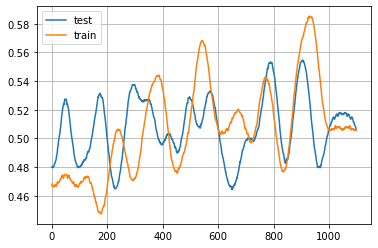

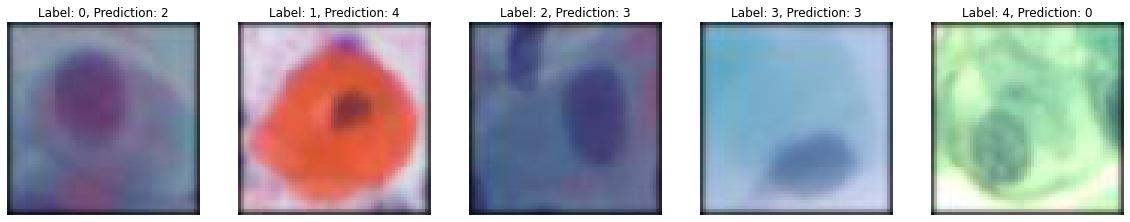

In [144]:
import matplotlib.pyplot as plt
# First, some preprocessing to smooth the training and testing arrays for display.
window_length = 100
train_s = np.r_[
    training[window_length - 1 : 0 : -1],
    training,
    training[-1:-window_length:-1],
]
test_s = np.r_[
    testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid")
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

# Display the training accuracies.
x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.legend(["test", "train"])
plt.grid()

train_set, test_images, test_labels = dataset.get_mini_dataset(
    eval_batch_size, eval_iters, shots, classes, split=True
)
for images, labels in train_set:
    with tf.GradientTape() as tape:
        preds = model(images)
        loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
test_preds = model.predict(test_images)
test_preds = tf.argmax(test_preds).numpy()

_, axarr = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for i, ax in zip(range(5), axarr):
    # If your test_images are normalized (0–1), scale them back to 0–255
    temp_image = test_images[i] * 255  
    temp_image = np.clip(temp_image, 0, 255).astype("uint8")

    ax.set_title(
        f"Label: {int(test_labels[i])}, Prediction: {test_preds[i]}"
    )
    ax.imshow(temp_image)   # no cmap → uses full RGB
    ax.axis("off")

plt.show()

[2, 0, 4]
0 2
(5, 64, 64, 3)
(15, 64, 64, 3)
(2832, 64, 64, 3)
1 0
(5, 64, 64, 3)
(15, 64, 64, 3)
(2832, 64, 64, 3)
2 4
(5, 64, 64, 3)
(15, 64, 64, 3)
(2832, 64, 64, 3)


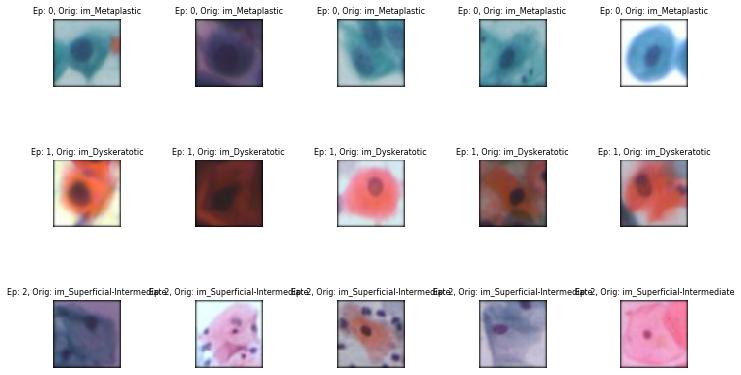

In [143]:

def visualize_fewshot_with_original_labels(images, episodic_labels, original_images, original_labels, class_indices, shots=5):
    """
    Visualize few-shot dataset images with both episodic and original labels.

    Args:
        images : np.ndarray
            Few-shot images, shape (N, H, W, C).
        episodic_labels : np.ndarray
            Episodic labels (0..num_classes-1).
        original_images : np.ndarray
            All source images loaded from train_data (N_all, H, W, C).
        original_labels : np.ndarray
            Original labels from train_data.classes (N_all,).
        class_indices : dict
            Mapping from class name -> index from train_data.class_indices.
        shots : int
            Number of images to show per episodic class.
    """
    idx_to_class = {v: k for k, v in class_indices.items()}  # reverse lookup
    
    num_classes = len(np.unique(episodic_labels))
    fig, axes = plt.subplots(num_classes, shots, figsize=(shots*2, num_classes*2))

    for class_idx in range(num_classes):
        # Pick images for this episodic class
        idxs = np.where(episodic_labels == class_idx)[0][:shots]
        
        for j, idx in enumerate(idxs):
            ax = axes[class_idx, j] if num_classes > 1 else axes[j]
            ax.imshow(images[idx])
            ax.axis("off")

            # --- Recover original label ---
            # Find the closest match in original_images
            diffs = np.mean(np.abs(original_images - images[idx]), axis=(1,2,3))
            nearest_idx = np.argmin(diffs)
            orig_label_idx = original_labels[nearest_idx]
            orig_class_name = idx_to_class[orig_label_idx]

            ax.set_title(f"Ep: {class_idx}, Orig: {orig_class_name}", fontsize=8)

    plt.tight_layout()
    plt.show()

# Get one mini-dataset
ds = train_dataset.get_mini_dataset(batch_size=16, repetitions=1, shots=5, num_classes=3)
images, episodic_labels = next(iter(ds))

# Visualize with original labels
visualize_fewshot_with_original_labels(
    images.numpy(),
    episodic_labels.numpy(),
    train_images,        # all loaded source images
    train_labels,        # all source integer labels
    train_data.class_indices,
    shots=5
)

In [150]:
import numpy as np
import tensorflow as tf
import random

class FewShotDataset:
    def __init__(self, images, labels, class_indices=None):
        """
        images: numpy array (N, H, W, C)
        labels: numpy array (N,) -> integer indices from train_data
        class_indices: dict from train_data.class_indices to map back to class names
        """
        self.images = images
        self.labels = labels
        self.unique_classes = np.unique(labels)

        # Map each label -> list of images
        self.data = {cls: images[labels == cls] for cls in self.unique_classes}

        # Optional: keep reverse lookup for original class names
        if class_indices:
            self.class_names = {v: k for k, v in class_indices.items()}
        else:
            self.class_names = None

    def get_mini_dataset(self, batch_size, repetitions, shots, num_classes, split=False):
        """
        Returns:
          ds: tf.data.Dataset (episode training set)
          test_images: numpy array of held-out images (if split=True)
          test_labels: numpy array of episode labels
          episode_to_original: dict mapping episodic labels -> original class ids
        """
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, *self.images.shape[1:]))

        if split:
            test_images = np.zeros((num_classes, *self.images.shape[1:]))
            test_labels = np.zeros(num_classes)

        # Sample random subset of classes
        label_subset = np.random.choice(self.unique_classes, num_classes, replace=False)

        # map episodic label (0..num_classes-1) -> original label id
        episode_to_original = {}

        for class_idx, class_obj in enumerate(label_subset):
            episode_to_original[class_idx] = class_obj
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx

            if split:
                images_to_split = random.sample(list(self.data[class_obj]), shots + 1)
                test_images[class_idx] = images_to_split[-1]
                test_labels[class_idx] = class_idx
                temp_images[class_idx * shots : (class_idx + 1) * shots] = np.array(images_to_split[:-1])
            else:
                selected_images = random.sample(list(self.data[class_obj]), shots)
                temp_images[class_idx * shots : (class_idx + 1) * shots] = np.array(selected_images)

        ds = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        ds = ds.shuffle(100).batch(batch_size).repeat(repetitions)

        if split:
            return ds, test_images, test_labels, episode_to_original
        else:
            return ds, episode_to_original

    def get_class_name(self, original_label):
        """Return human-readable class name if available"""
        if self.class_names:
            return self.class_names.get(original_label, str(original_label))
        return str(original_label)

In [160]:
def display_episode(test_images, test_labels, episode_to_original, dataset, num_to_show=5):
    """
    Display images from an episode with both episodic and original labels.

    test_images: np.array of episode images
    test_labels: np.array of episodic labels (0..num_classes-1)
    episode_to_original: dict mapping episodic label -> original label id
    dataset: FewShotDataset instance (to recover class names)
    num_to_show: number of images to plot
    """
    fig, axes = plt.subplots(1, num_to_show, figsize=(20, 5))

    for i, ax in zip(range(num_to_show), axes):
        img = test_images[i]

        # If grayscale, convert to 3-channel for display
        if img.shape[-1] == 1:
            img = np.stack((img[..., 0],) * 3, axis=-1)
            
        if img.max() <= 1.0:
            img = (img * 255).astype("uint8")
        else:
            img = img.astype("uint8")

        episodic_label = int(test_labels[i])
        original_label = episode_to_original[episodic_label]
        class_name = dataset.get_class_name(original_label)

        ax.imshow(img.astype("uint8"))
        ax.set_title(f"Episodic: {episodic_label}\nOriginal: {class_name}", fontsize=10)
        ax.axis("off")

    plt.show()

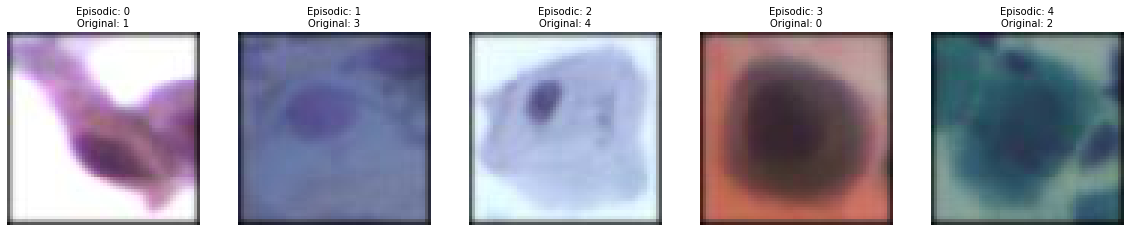

In [161]:
train_set, test_images, test_labels, mapping = train_dataset.get_mini_dataset(
    batch_size=16, repetitions=1, shots=5, num_classes=5, split=True
)

display_episode(test_images, test_labels, mapping, train_dataset, num_to_show=5)